# RL perceptron

## December 2021

In this notebook, we recall the ODE analysis of three classic algorithms to train a perceptron in the teacher-student setup.

We then give an alternative learning rule inspired by reinforcement learning, where we provide the student with sparse Hebbian rewards, and state the set of ODEs that describe the learning dynamics in this case.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import glob
import math
import os.path

import numpy as np
import numpy.random as rnd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc("font", **{"size": 20})
plt.rc("lines", linewidth=4.0)
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2

fig_size = 6

# A teacher for all situations

We draw one teacher from the hypersphere in D dimensions and normalise its weight vector.

In [2]:
# input dimension
D = 400

# Choose a random teacher
w_teacher = rnd.randn(D)
w_teacher /= np.sqrt(w_teacher @ w_teacher / D)

def test_accuracy(w_stu, w_tea):
    """
    Returns the test accuracy for a teacher-student pair with the given weight vectors.
    """
    angle = (w_stu @ w_tea / 
             np.linalg.norm(w_stu) / np.linalg.norm(w_tea))
    return 1 - 1 / np.pi * np.arccos(angle)

In terms of the order parameters, we have for the accuracy

In [3]:
def test_accuracy_op(Q, R, T):
    """
    Returns the test accuracy for a teacher-student pair with the given overlaps.
    """
    return 1 - 1 / np.pi * np.arccos(R / np.sqrt(Q * T))


# Reminder: Standard perceptron

We first remind ourselves of the different algorithms to train a perceptron on a perceptron teacher with different learning rules: hebbian, Perceptron, and AdaTron.

## Three learning rules

We first implement the three standard learning rules for the perceptron in supervised learning: the hebbian, perceptron and AdaTron learning rules.

In [4]:
def learning_rule(rule, w, x, y):
    """
    Calculates the weight update for the given learning rule.
    
    Parameters:
    -----------
    rule: hebbian | perceptron | adatron
    w : (D)
        student weight vector
    x : (D)
        input
    y : scalar
        true label
    """
    # the prefactor allows to choose different learning rules
    if rule == "hebbian":
        F = 1  # hebbian case
    elif rule == "perceptron":
        y_hat = np.sign(w @ x)      # predicted label
        F = np.heaviside(-y * y_hat, 0.5)
    elif rule == "adatron":
        y_hat = np.sign(w @ x)      # predicted label
        F = np.heaviside(-y * y_hat, 0.5) * np.abs(w @ x) / np.sqrt(D)
    else:
        raise ValueError("Did not recognise learning rule")

    dw = y * x * F

    return dw

## Simulation

Here we simulate training of a single student with the three algorithms

In [5]:
# student weight vectors
std0 = 1  # std dev of the initial student weights.
w_student = {"hebbian":       std0 * rnd.randn(D), 
             "perceptron": std0 * rnd.randn(D),
             "adatron":    std0 * rnd.randn(D)
            }

# learning rates
lr = {"hebbian":    1,
      "perceptron": 1,
      "adatron":    1
      }

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_init = copy.deepcopy(w_student)

step = 0
num_steps = 500 * D

steps_sim = []
accuracies_sim = dict()
for algo in w_student.keys():
    accuracies_sim[algo] = []

while step < num_steps:
    for _, (algo, w) in enumerate(w_student.items()):
        # sample new input, output pair
        x = rnd.randn(D)
        y = np.sign(w_teacher @ x)
        
        w += lr[algo] / np.sqrt(D) * learning_rule(algo, w, x, y)

    if step % D == 0:
        steps_sim += [step]
        for _, (algo, w) in enumerate(w_student.items()):
            accuracies_sim[algo] += [test_accuracy(w, w_teacher)]
    step += 1

Let's have a look at the accuracy over time:

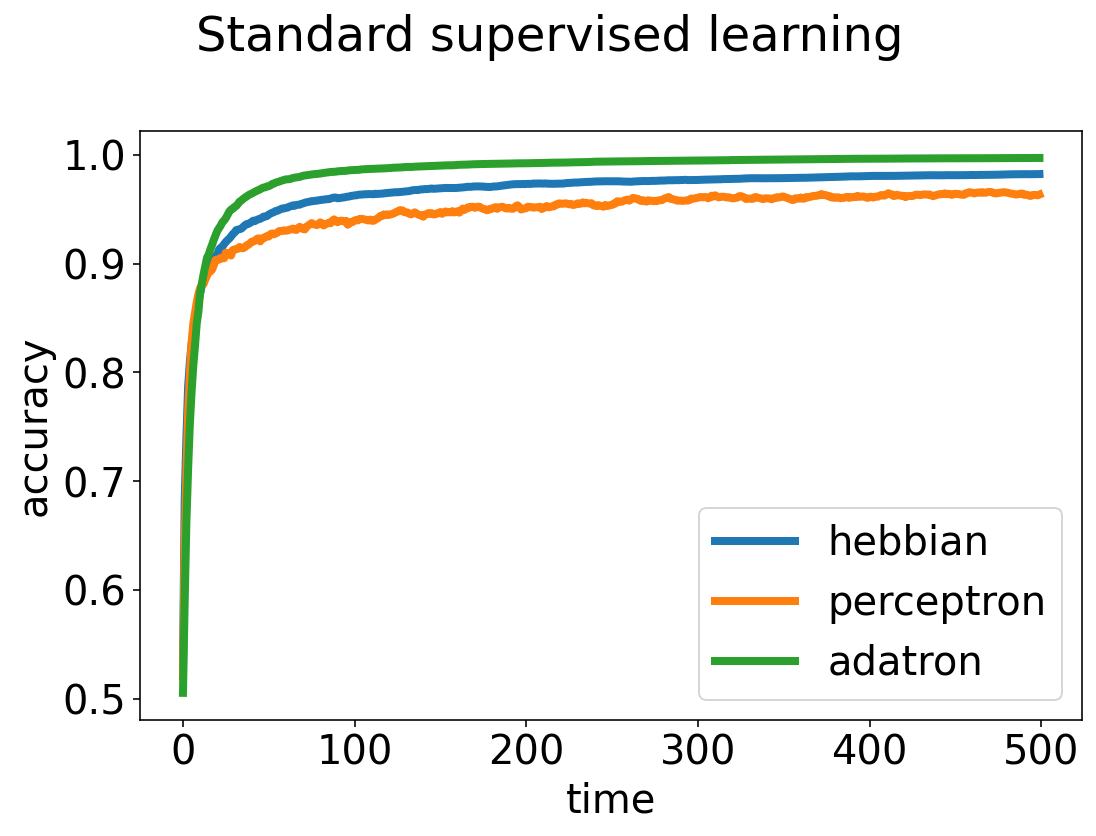

In [6]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("Standard supervised learning")
for algo in w_student.keys():
    ax.plot(np.array(steps_sim) / D, accuracies_sim[algo], label=algo)
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

That looks like what one would expect from the literature, cf. Secs 9.1f in Engel & van den Broeck (2001).

## ODE analysis

The following code integrates the ODEs for the order parameters for a perceptron trained with all three supervised algorithms.

In [7]:
Q = dict()
R = dict()

# Initial conditions for the order parameters
for _, (algo, w) in enumerate(w_init.items()):
    Q[algo] = w @ w / D
    R[algo] = w @ w_teacher / D
T = w_teacher @ w_teacher / D

# Integrate equations of motion
step = 0
steps_ode = []
accuracies_ode = dict()
for algo in w_student.keys():
    accuracies_ode[algo] = []

dt = 1 / D

while step < num_steps:
    for algo in w_student.keys():
        # compute the update of the order parameters depending on the algorithm
        if algo == "hebbian":
            dR = np.sqrt(2 / np.pi)
            dQ = lr[algo] + 2 * R[algo] * np.sqrt(2 / np.pi)
        elif algo == "perceptron":
            rho = R[algo] / np.sqrt(Q[algo])
            dR = 1 / np.sqrt(2 * np.pi) * (1 - rho)
            dQ = (lr[algo] / np.pi * np.arccos(rho) 
                  + np.sqrt(2 / np.pi) * (R[algo] - np.sqrt(Q[algo])))
        elif algo == "adatron":
            sqrtQminR2 = np.sqrt(Q[algo] - R[algo]**2)
            dR = sqrtQminR2 / np.pi + R[algo] * (np.arctan(R[algo] / sqrtQminR2) / np.pi - 1/2)
            dQ = R[algo] * sqrtQminR2 / np.pi + Q[algo] * (np.arctan(R[algo] / sqrtQminR2) / np.pi - 1/2)
        else:
            raise ValueError("Did not recognise learning rule")

        R[algo] += dt * lr[algo] * dR
        Q[algo] += dt * lr[algo] * dQ

    # logging
    if step % D == 0:
        steps_ode += [step]
        for algo in w_student.keys():
            accuracies_ode[algo] += [test_accuracy_op(Q[algo], R[algo], T)]
    step += 1

The following plot confirms the accuracy of these equations even for moderate system sizes ($D=1000$)

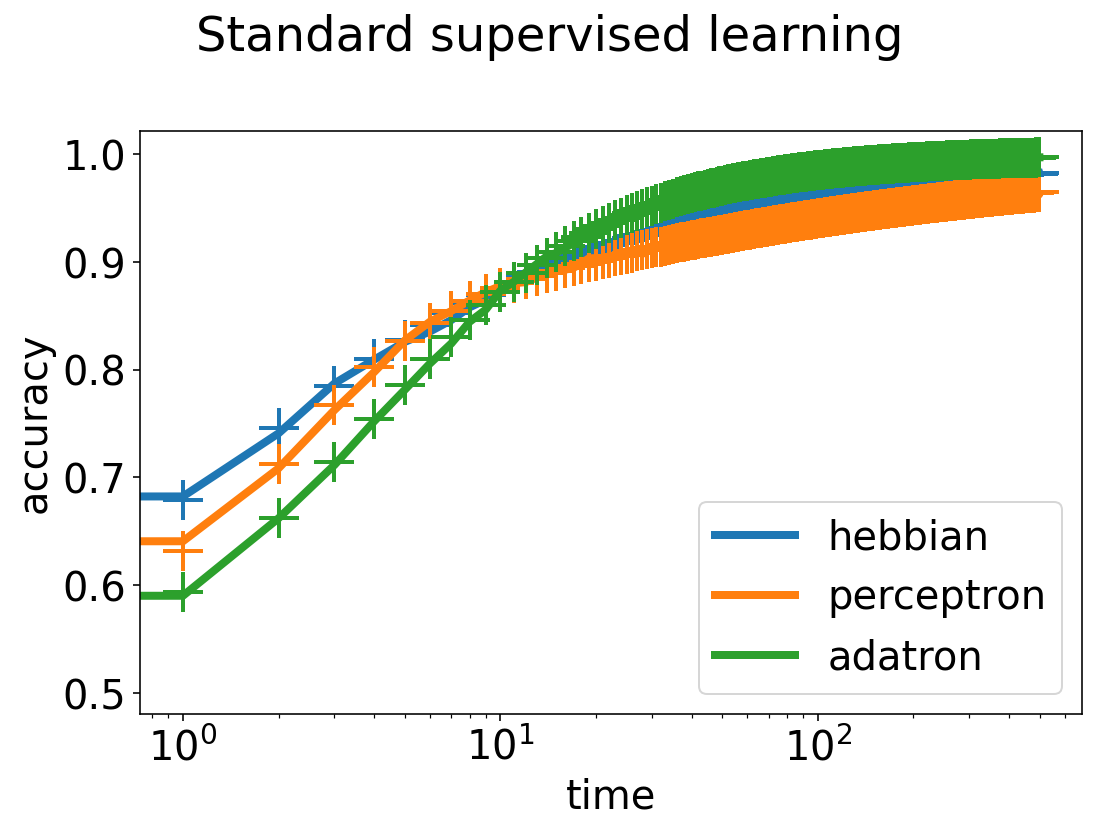

In [8]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("Standard supervised learning")
for algo_idx, algo in enumerate(w_student.keys()):
    color = "C" + str(algo_idx)
    ax.semilogx(np.array(steps_sim) / D, accuracies_sim[algo], label=algo, color=color)
    ax.semilogx(np.array(steps_ode) / D, accuracies_ode[algo], "+", color=color)
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

# Reinforcement learning

Now we go from a supervised to a reinforcement learning scenario with sparse rewards.

For a teacher with weights $w^* \in \mathbb{R}^D$ providing a label
\begin{equation}
    y = \mathrm{sgn}(\nu); \qquad \nu \equiv \frac{w^* x}{\sqrt D}
\end{equation}
and a student with weights $w \in \mathbb{R}^D$ providing the estimate
\begin{equation}
    \hat y = \mathrm{sgn}(\lambda); \qquad \lambda \equiv \frac{w x}{\sqrt D}
\end{equation}
we have the RL Perceptron learning rule
\begin{equation}
   w^{\mu+1}_i = w^{\mu}_i + \frac{\eta}{\sqrt D} \left(  \frac{1}{T} \sum_{t=1}^T x_i^t y^t \right) \prod_{s=1}^T \theta(y^s \hat y^s)
\end{equation}
where $T$ is the episode length.

In the limiting case $T=1$, we do *not* get back the perceptron learning rule; the percetron algorithm only updates the weights when the student made an error, hence the Hebbian update is modulated by $\theta(-y \hat y)$, contrary to the *reward* $\theta(y \hat y)$ that appears in the RL learning rule.

Note that the normalisation of the local fields $\lambda$ and $\nu$ is not strictly necessary, but it does simplify the bookkeeping during the following analysis.\

## Simulation

We will simulate reinforcement learning with the Hebbian reward for various episode lengths:

In [9]:
Ts = [1, 2, 3, 10]

In [10]:
# student weight vectors
std0 = 1  # std dev of the initial student weights.

w_rl_student = dict()
for T in Ts:
    w_rl_student[T] = rnd.randn(D)
    
w_rl_init = copy.deepcopy(w_rl_student)

# learning rates
lr = 1

# make a copy of the initial conditions of the students for 
# later comparisons with the ODE integration
w_rl_init = copy.deepcopy(w_rl_student)

step = 0
num_steps = 5000 * D

steps_rl_sim = []
accuracies_rl_sim = dict()
for T in Ts:
    accuracies_rl_sim[T] = []
R_rl_sim = copy.deepcopy(accuracies_rl_sim)
Q_rl_sim = copy.deepcopy(accuracies_rl_sim)

while step < num_steps:
    for T in Ts:
        # sample new input, output pair
        xs = rnd.randn(T, D)
        ys = np.sign(w_teacher @ xs.T)

        ypred = np.sign(w_rl_student[T] @ xs.T)

        reward = np.all(ys == ypred)

        hebbian_update = np.mean(ys[:, None] * xs, axis=0)

        w_rl_student[T] += lr / np.sqrt(D) * reward * hebbian_update
    
    if step % D == 0:
        steps_rl_sim += [step]
        for T in Ts:
            accuracies_rl_sim[T] += [test_accuracy(w_rl_student[T], w_teacher)]
            R_rl_sim[T] += [w_teacher @ w_rl_student[T] / D]
            Q_rl_sim[T] += [w_rl_student[T] @ w_rl_student[T] / D]
            
    step += 1

In the following plot, we show the result of reinforcement learning for different episode lengths. 

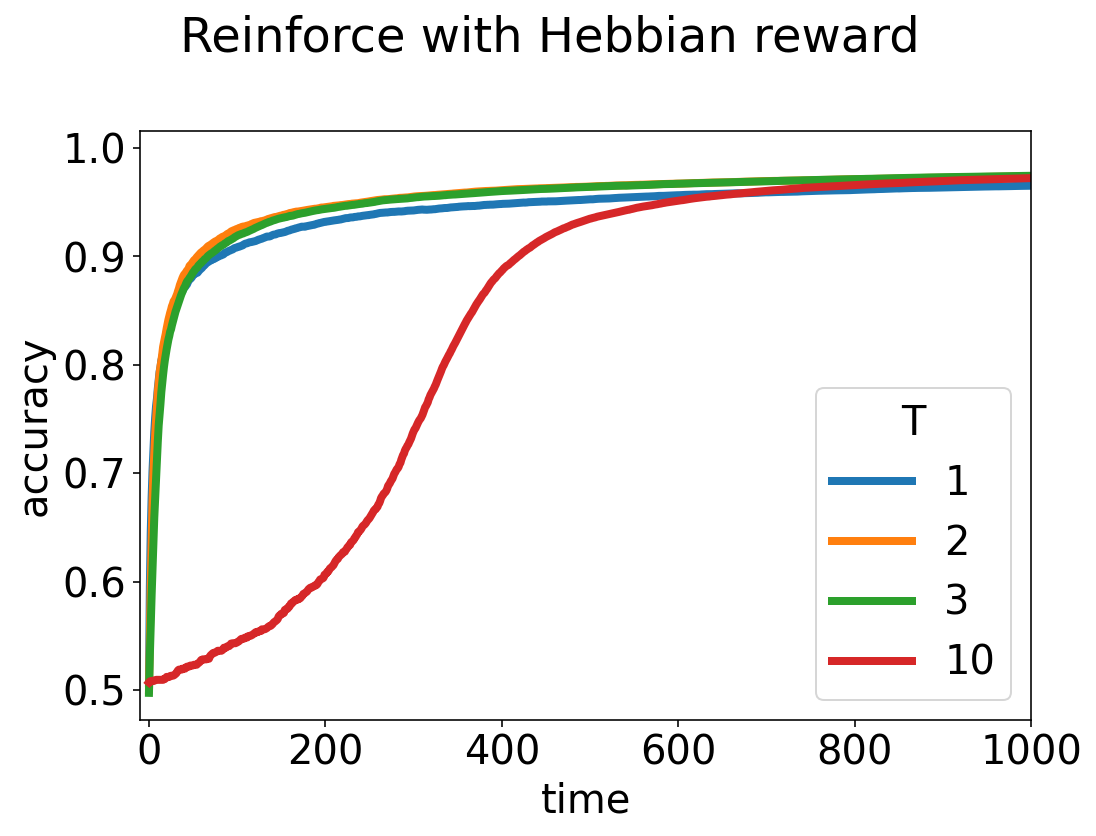

In [11]:
fig, ax = plt.subplots(figsize=(4 /3 * fig_size, fig_size))
fig.suptitle("Reinforce with Hebbian reward")
for T in Ts:
    ax.plot(np.array(steps_rl_sim) / D, accuracies_rl_sim[T], label=T)
# ax.plot(np.array(steps_sim) / D, accuracies_sim["perceptron"], "--", color="C0", label="Perceptron")
ax.legend(title="T")
ax.set_xlabel("time")
ax.set_xlim(left=-10, right=1000)
ax.set_ylabel("accuracy")
# ax.set_ylim(top=1)
plt.tight_layout()
plt.show()

## ODE analysis

We also derived a set of ODEs that describe the dynamics of the order parameters for this algorithm.

\begin{equation}
    Q \equiv \frac{w w}{D}; \qquad R \equiv \frac{w^* w}{D}
\end{equation}

For $R$, we have
\begin{align}
    \frac{d R}{dt} &= \frac{\eta}{T} \sum_t \langle \nu^t \mathrm{sgn}(\nu^t) \theta(\nu^t \lambda^t)\rangle \langle \prod_{t'\neq t}^T \theta(\nu^{t'} \lambda^{t'})\rangle
\end{align}

In [7]:
Q = dict()
R = dict()

# Initial conditions for the order parameters
for T in Ts:
    Q[T] = w_rl_init[T] @ w_rl_init[T] / D
    R[T] = w_rl_init[T] @ w_teacher / D

# Integrate equations of motion
step = 0
steps_rl_ode = []
accuracies_rl_ode = dict()
for T in Ts:
    accuracies_rl_ode[T] = []
R_rl_ode = copy.deepcopy(accuracies_rl_ode)    
Q_rl_ode = copy.deepcopy(accuracies_rl_ode)

dt = 1 / D

while step < num_steps:
    for T in Ts:
        # compute the probability that one, all-but-one, or all predictions were correct
        p_correct = (1 - 1 / np.pi * np.arccos(R[T] / np.sqrt(Q[T])))
        p_correct_others = p_correct**(T-1)
        p_correct_all = p_correct**T

        # 
        dR = 1 / np.sqrt(2 * np.pi) * (1 + R[T] / np.sqrt(Q[T])) * p_correct_others
        dQ = (np.sqrt(2 / np.pi) * (np.sqrt(Q[T]) + R[T]) * p_correct_others
              + lr / T * p_correct_all)
        
        R[T] += dt * lr * dR
        Q[T] += dt * lr * dQ

    if step % D == 0:
        steps_rl_ode += [step]
        for T in Ts:
            accuracies_rl_ode[T] += [test_accuracy_op(Q[T], R[T], 1)]
            R_rl_ode[T] += [R[T]]
            Q_rl_ode[T] += [Q[T]]
    step += 1

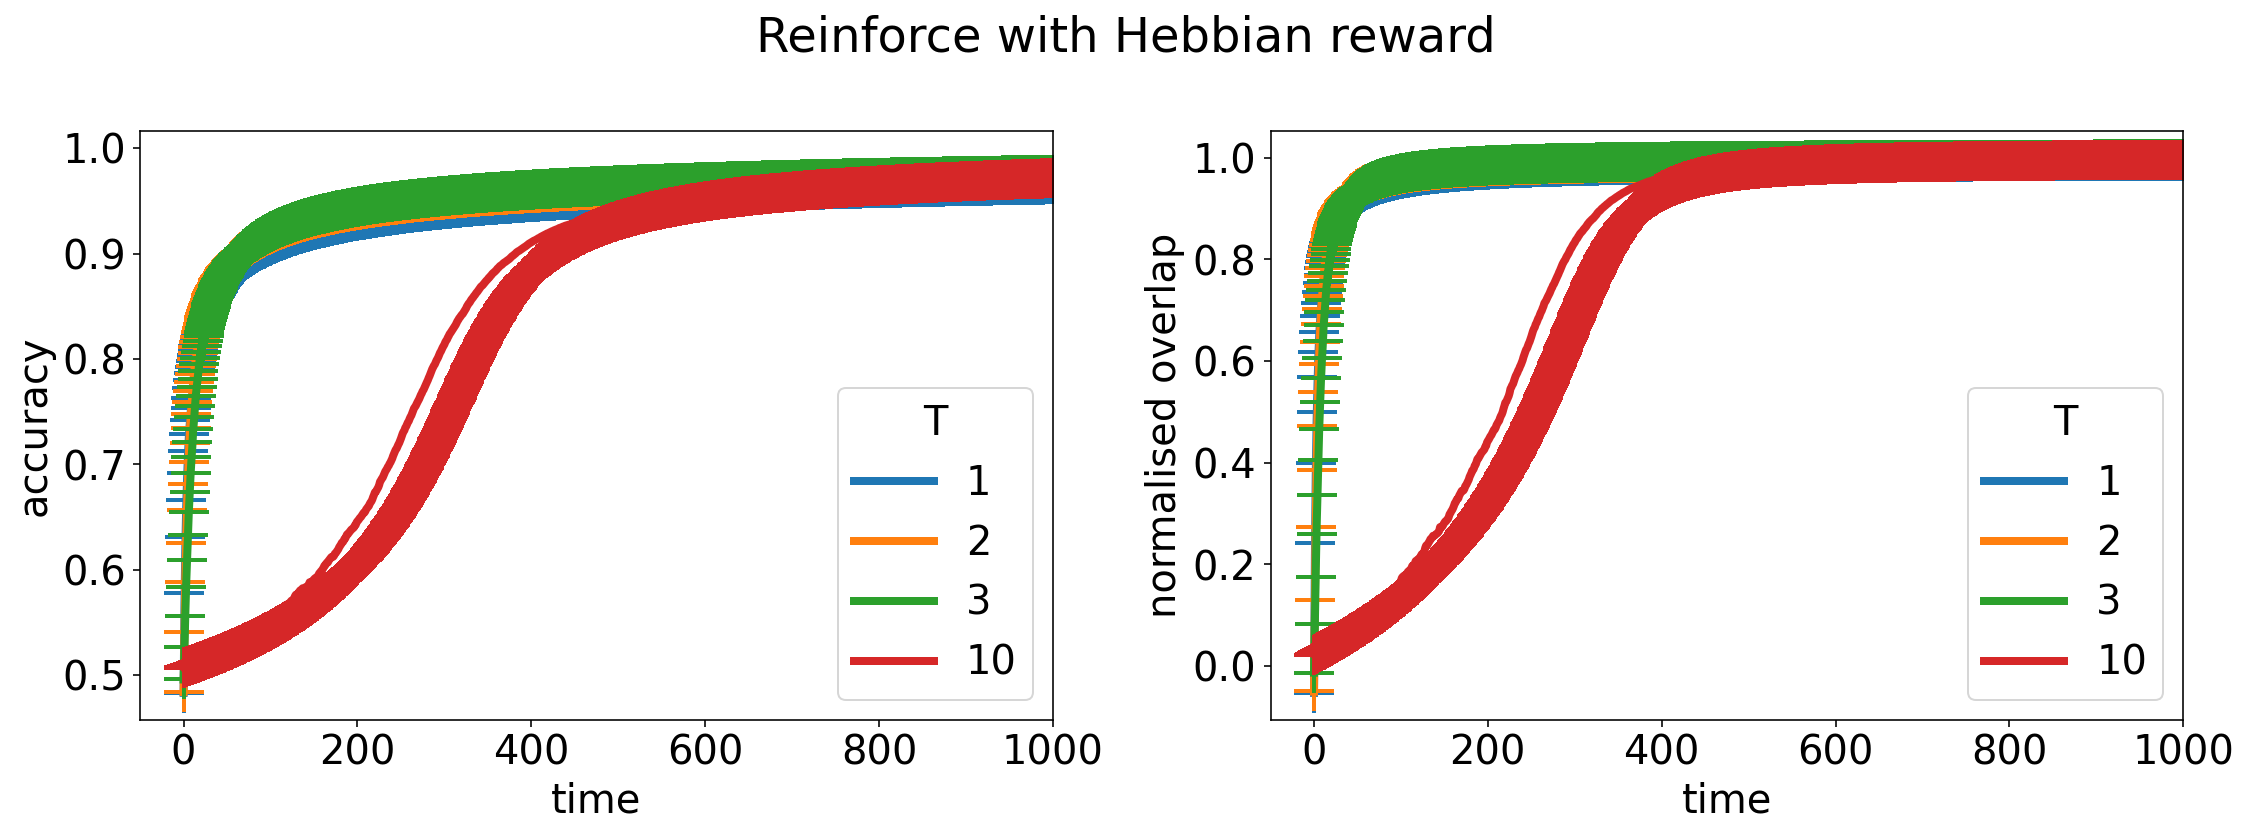

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(4 /3 * 2 * fig_size, fig_size))
fig.suptitle("Reinforce with Hebbian reward")

time_sim = np.array(steps_rl_sim) / D
time_ode = np.array(steps_rl_ode) / D

for T_idx, T in enumerate(Ts):
    color = "C" + str(T_idx)
    axes[0].plot(time_sim, accuracies_rl_sim[T], label=T, color=color)
    axes[0].plot(time_ode, accuracies_rl_ode[T], "+", color=color)
    
    axes[1].plot(time_sim, R_rl_sim[T] / np.sqrt(Q_rl_sim[T]), label=T, color=color)
    axes[1].plot(time_ode, R_rl_ode[T] / np.sqrt(Q_rl_ode[T]), "+", color=color)

axes[0].set_ylabel("accuracy")
axes[1].set_ylabel("normalised overlap")
for i in range(2):
    axes[i].set_xlim(left=-50, right=1000)
    axes[i].legend(title="T")
    axes[i].set_xlabel("time")
plt.tight_layout()
plt.show()

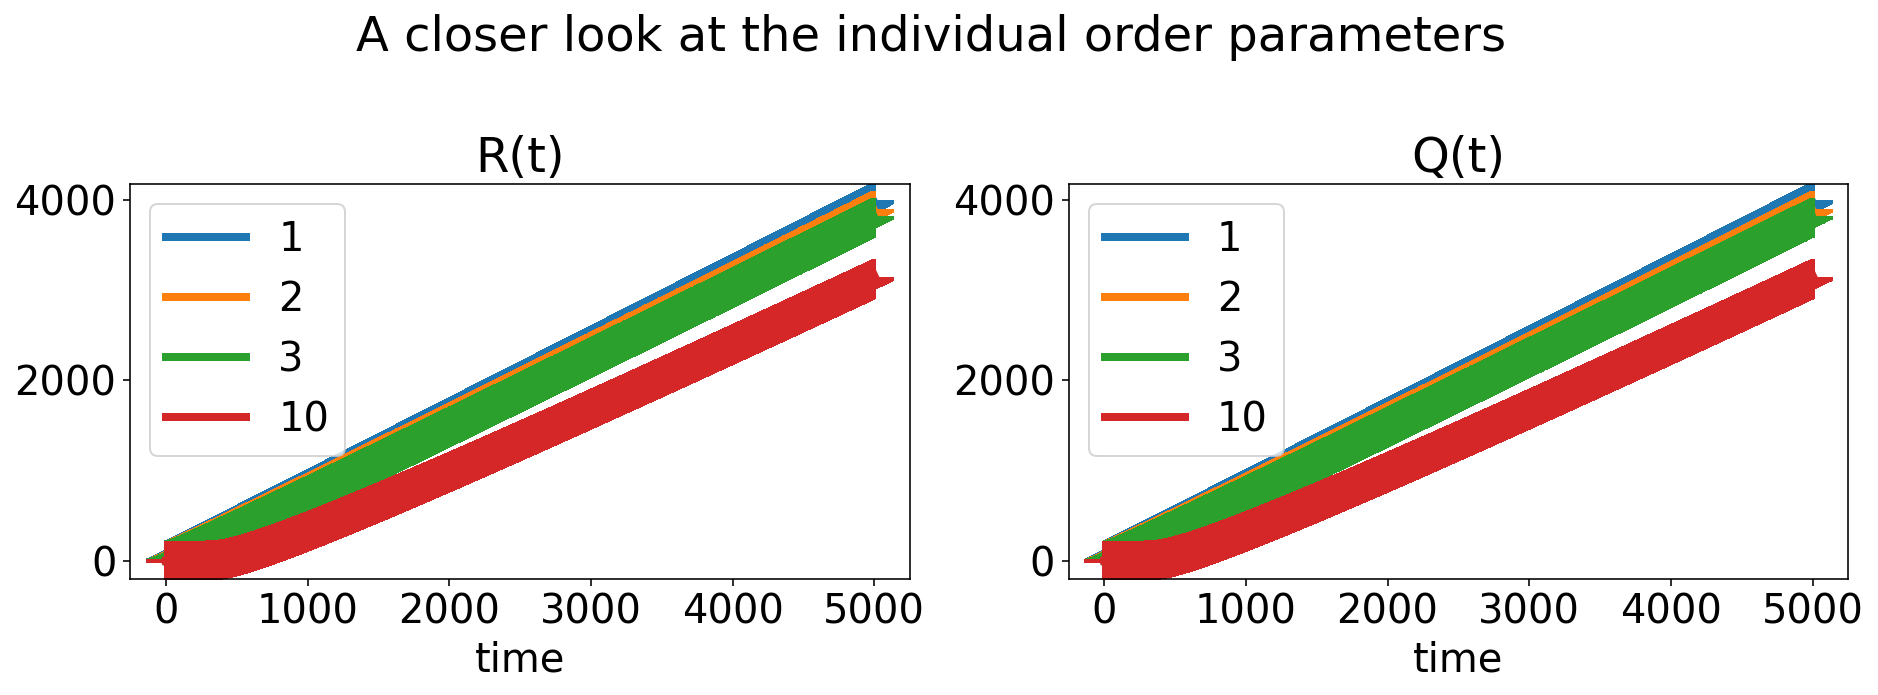

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4 /3 * 2 * 5, 5))
fig.suptitle("A closer look at the individual order parameters")

axes[0].set_title("R(t)")
axes[1].set_title("Q(t)")

for T_idx, T in enumerate(Ts):
    color = "C" + str(T_idx)
    axes[0].plot(time_sim, R_rl_sim[T], label=T, color=color)
    axes[0].plot(time_ode, R_rl_ode[T], "+", color=color)
    axes[1].plot(time_sim, R_rl_sim[T], label=T, color=color)
    axes[1].plot(time_ode, R_rl_ode[T], "+", color=color)

for i in range(2):
    axes[i].legend()
    axes[i].set_xlabel("time")
plt.tight_layout()
plt.show()

The order parameters show the typical behaviour of Hebbian (or indeed, perceptron) learning rules: the weights grow indefinitely in the online setting. It would be interesting to extend the analysis to a learning rule that includes an Adatron-like term $\left| \frac{w x}{\sqrt D}\right|$.